In [ ]:
import numpy as np
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
import spacy
import string
import pandas as pd
import numpy as np
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, InputLayer, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dropout, Dense, Flatten, InputLayer
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow import keras
from sklearn.utils import class_weight
from gensim.scripts.glove2word2vec import glove2word2vec
from matplotlib import pyplot as plt
import seaborn

# Import Data

In [ ]:
from google.colab import drive

In [ ]:
drive.mount('drive')

Mounted at drive


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv', usecols=['reviews.text', 'reviews.rating'])

In [ ]:
data

,reviews.rating,reviews.text
0,3,I order 3 of them and one of the item is bad q...
1,4,Bulk is always the less expensive way to go fo...
2,5,Well they are not Duracell but for the price i...
3,5,Seem to work as well as name brand batteries a...
4,5,These batteries are very long lasting the pric...
...,...,...
28327,5,I got 2 of these for my 8 yr old twins. My 11 ...
28328,4,I bought this for my niece for a Christmas gif...
28329,5,"Very nice for light internet browsing, keeping..."
28330,5,This Tablet does absolutely everything I want!...


Rename Columns

In [ ]:
data.rename(columns = {'reviews.rating':'rating', 'reviews.text':'reviews'}, inplace = True)

In [ ]:
data

,rating,reviews
0,3,I order 3 of them and one of the item is bad q...
1,4,Bulk is always the less expensive way to go fo...
2,5,Well they are not Duracell but for the price i...
3,5,Seem to work as well as name brand batteries a...
4,5,These batteries are very long lasting the pric...
...,...,...
28327,5,I got 2 of these for my 8 yr old twins. My 11 ...
28328,4,I bought this for my niece for a Christmas gif...
28329,5,"Very nice for light internet browsing, keeping..."
28330,5,This Tablet does absolutely everything I want!...


Check for missing data

In [ ]:
miss = 0

for i in range(len(data['reviews'])):
  if not data['reviews'][i] or not data['rating'][i]:
    miss = miss + 1
    data.drop([i], inplace=True)
  
print("No. of rows with missing values: ", miss)

if miss > 0:
  data.reset_index(drop=True, inplace=True)

No. of rows with missing values:  0


Annotate Reviews with Sentiments
We will annotate the sentiments as follows:


*   Negative ==> -1
*   Neutral  ==> 0
*   Positive ==> 1





In [ ]:
data['sentiment'] = data['rating']

for i in range(len(data)):
  if data['rating'][i] <=2:
    data['sentiment'][i] = -1
  elif data['rating'][i] == 3:
    data['sentiment'][i] = 0
  else:
    data['sentiment'][i] = 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [ ]:
data[:20]

,rating,reviews,sentiment
0,3,I order 3 of them and one of the item is bad q...,0
1,4,Bulk is always the less expensive way to go fo...,1
2,5,Well they are not Duracell but for the price i...,1
3,5,Seem to work as well as name brand batteries a...,1
4,5,These batteries are very long lasting the pric...,1
5,5,Bought a lot of batteries for Christmas and th...,1
6,5,ive not had any problame with these batteries ...,1
7,5,Well if you are looking for cheap non-recharge...,1
8,3,These do not hold the amount of high power jui...,0
9,4,AmazonBasics AA AAA batteries have done well b...,1


Remove 'rating' column

In [ ]:
del data['rating']

In [ ]:
data

,reviews,sentiment
0,I order 3 of them and one of the item is bad q...,0
1,Bulk is always the less expensive way to go fo...,1
2,Well they are not Duracell but for the price i...,1
3,Seem to work as well as name brand batteries a...,1
4,These batteries are very long lasting the pric...,1
...,...,...
28327,I got 2 of these for my 8 yr old twins. My 11 ...,1
28328,I bought this for my niece for a Christmas gif...,1
28329,"Very nice for light internet browsing, keeping...",1
28330,This Tablet does absolutely everything I want!...,1


# Data Preprocessing
Lowercase reviews text

In [ ]:
data['reviews'] = data['reviews'].str.lower()

In [ ]:
data

,reviews,sentiment
0,i order 3 of them and one of the item is bad q...,0
1,bulk is always the less expensive way to go fo...,1
2,well they are not duracell but for the price i...,1
3,seem to work as well as name brand batteries a...,1
4,these batteries are very long lasting the pric...,1
...,...,...
28327,i got 2 of these for my 8 yr old twins. my 11 ...,1
28328,i bought this for my niece for a christmas gif...,1
28329,"very nice for light internet browsing, keeping...",1
28330,this tablet does absolutely everything i want!...,1


Remove non-ascii characters

In [ ]:
#function to remove non-ascii character
def remove_non_ascii(string):
    non_ascii_removed = ""
    for char in string:
        if ord(char) < 128:
            non_ascii_removed = non_ascii_removed + char
    return non_ascii_removed

In [ ]:
for i in range(len(data['reviews'])):
    data['reviews'][i] = remove_non_ascii(data['reviews'][i] )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
data

,reviews,sentiment
0,i order 3 of them and one of the item is bad q...,0
1,bulk is always the less expensive way to go fo...,1
2,well they are not duracell but for the price i...,1
3,seem to work as well as name brand batteries a...,1
4,these batteries are very long lasting the pric...,1
...,...,...
28327,i got 2 of these for my 8 yr old twins. my 11 ...,1
28328,i bought this for my niece for a christmas gif...,1
28329,"very nice for light internet browsing, keeping...",1
28330,this tablet does absolutely everything i want!...,1


Replace Punctuations, New Line, Carriage Return and Tab with White Space

In [ ]:
#remove punctuations, newline etc with white space
regex = re.compile('[' + re.escape(string.punctuation) + '\\r\\t\\n]')
for i in range(len(data['reviews'])):
    data['reviews'][i] = regex.sub(" ", str(data['reviews'][i]))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
data

,reviews,sentiment
0,i order 3 of them and one of the item is bad q...,0
1,bulk is always the less expensive way to go fo...,1
2,well they are not duracell but for the price i...,1
3,seem to work as well as name brand batteries a...,1
4,these batteries are very long lasting the pric...,1
...,...,...
28327,i got 2 of these for my 8 yr old twins my 11 ...,1
28328,i bought this for my niece for a christmas gif...,1
28329,very nice for light internet browsing keeping...,1
28330,this tablet does absolutely everything i want ...,1


Stopwords Removal

In [ ]:
#download stopwords from nltk library
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
#get english stop words
stopwords = set(stopwords.words('english'))

In [ ]:
data['reviews'] = data['reviews'].apply(lambda x : ' '.join([word for word in x.split() if word not in (stopwords)]))

In [ ]:
data

,reviews,sentiment
0,order 3 one item bad quality missing backup sp...,0
1,bulk always less expensive way go products like,1
2,well duracell price happy,1
3,seem work well name brand batteries much bette...,1
4,batteries long lasting price great,1
...,...,...
28327,got 2 8 yr old twins 11 yr old one one better ...,1
28328,bought niece christmas gift 9 years old love,1
28329,nice light internet browsing keeping top email...,1
28330,tablet absolutely everything want watch tv sho...,1


Lemmatization

In [ ]:
#load spacy english model
nlp = spacy.load('en_core_web_sm')

In [ ]:
#function to:
#use loaded english model to tokenize the news headlines into words
#then use the tokenized words to get their baseforms or lemma to replace them
def lemmatization(nlp, data):
  for i, sentence in enumerate(data):    
      doc = nlp(sentence, disable=['parser','ner'])
      data[i] = [token.lemma_ for token in doc]
  return data

In [ ]:
data['reviews'] = lemmatization(nlp, data['reviews'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [ ]:
data

,reviews,sentiment
0,"[order, 3, one, item, bad, quality, miss, back...",0
1,"[bulk, always, less, expensive, way, go, produ...",1
2,"[well, duracell, price, happy]",1
3,"[seem, work, well, name, brand, battery, much,...",1
4,"[battery, long, last, price, great]",1
...,...,...
28327,"[get, 2, 8, yr, old, twin, 11, yr, old, one, o...",1
28328,"[buy, niece, christmas, gift, 9, year, old, love]",1
28329,"[nice, light, internet, browsing, keep, top, e...",1
28330,"[tablet, absolutely, everything, want, watch, ...",1


Removing potential spam reviews. Remove reviews with more than 100 words.

In [ ]:
for i in range(len(data['reviews'])):
  if len(data['reviews'][i]) > 100:
    data.drop([i], inplace=True)

data.reset_index(drop=True, inplace=True)

In [ ]:
data

,reviews,sentiment
0,"[order, 3, one, item, bad, quality, miss, back...",0
1,"[bulk, always, less, expensive, way, go, produ...",1
2,"[well, duracell, price, happy]",1
3,"[seem, work, well, name, brand, battery, much,...",1
4,"[battery, long, last, price, great]",1
...,...,...
28196,"[get, 2, 8, yr, old, twin, 11, yr, old, one, o...",1
28197,"[buy, niece, christmas, gift, 9, year, old, love]",1
28198,"[nice, light, internet, browsing, keep, top, e...",1
28199,"[tablet, absolutely, everything, want, watch, ...",1


Check if dataset is balanced

In [ ]:
data['sentiment'].value_counts()

 1    25443
-1     1564
 0     1194
Name: sentiment, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


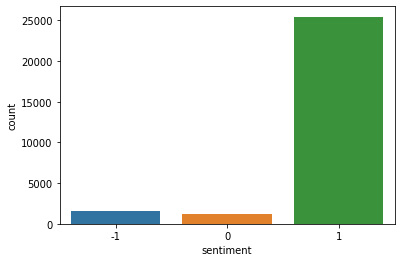

In [ ]:
seaborn.countplot(data['sentiment'])

# Building Dataset

Split dataset into 80% training set and 20% testing set.

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(data['reviews'], data['sentiment'], test_size = 0.2, random_state = 10)

In [ ]:
len(x_test)

5641

# Data Transformation: Converting Words to Word Embeddings

Load Pretrained GloVe

In [ ]:
glove_embeddings = {}
f = open('/content/drive/MyDrive/Colab Notebooks/glove.6B.100d.txt', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    glove_embeddings[word] = coefs
f.close()

Get the maximum number of words in a headline from Training and Testing set

In [ ]:
#get the number of words in the longest headline
max = 0

for i, sentence in enumerate(x_train):
  if len(sentence) > max:
    max = len(sentence)

for sentence in enumerate(x_test):
  if len(sentence) > max:
    max = len(sentence)

num_words = max
print("Number of words in longest sentence: ", num_words)

Number of words in longest sentence:  100


In [ ]:
def glove2embedding(data, glove, num_words):
  # get the dimensionality of vectors
  dimension = glove["the"].shape[0]

  X = np.zeros((len(data), num_words, dimension))
  for s, sentence in enumerate(data):
    for w, word in enumerate(sentence):
      vec = None
      try:
        vec = glove.get(word)
      except KeyError:
        pass
      if vec is not None:
        X[s][w] = np.array(vec)
      else:
        vec = glove.get("<unk>")
        X[s][w] = np.array(vec)
  return X

Vectorize words to word vectors (embeddings)

In [ ]:
# Get the word embeddings for the train, test, and validation dataset
x_train_vector = glove2embedding(x_train, glove_embeddings, num_words)
x_test_vector = glove2embedding(x_test, glove_embeddings, num_words)

In [ ]:
x_train_vector = np.asarray(x_train_vector)
x_test_vector = np.asarray(x_test_vector)
y_train = np.asarray(y_train)
y_test = np.asarray(y_test)

# Hyperparameter Tuning for Model

In [ ]:
pip install -q -U keras-tuner

     |████████████████████████████████| 133 kB 7.4 MB/s 


In [ ]:
import keras_tuner as kt

In [ ]:
def model_builder(hp):
  model = keras.Sequential()
  model.add(InputLayer(input_shape=(100, 100)))

  for i in range(hp.Int('no_layers', min_value=0, max_value=3)):
    model.add(Bidirectional(LSTM(hp.Int(f'units_{i+1}', min_value=4, max_value=64, step=4), return_sequences=True, kernel_regularizer=l2(0.02))))

  model.add(Bidirectional(LSTM(hp.Int('units_final', min_value=4, max_value=64, step=4), kernel_regularizer=l2(0.02))))
  model.add(Dropout(0.2))
  model.add(Dense(hp.Int('dense_node', min_value=4, max_value=64, step=4), activation='relu'))
  model.add(Dense(3, activation='softmax'))

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp.Float('learning_rate', min_value=0.0001, max_value=0.02)),
                loss='categorical_crossentropy',
                metrics=['accuracy', tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])

  return model

In [ ]:
model_tuner = kt.BayesianOptimization(model_builder,
                                objective=kt.Objective("val_recall", "max"),
                                max_trials=50,
                                directory='/content/drive/MyDrive/Colab Notebooks/cmt423 model tuning/bilstm/'
                                )

INFO:tensorflow:Reloading Oracle from existing project /content/drive/MyDrive/Colab Notebooks/cmt423 model tuning/bilstm/untitled_project/oracle.json


In [ ]:
model_tuner.search(x_train_vector, to_categorical(y_train,3), epochs=5, validation_data=(x_test_vector, to_categorical(y_test,3)))

In [ ]:
model_tuner.get_best_models()[0].summary()

(100, 100)

In [ ]:
model_tuner.get_best_hyperparameters()[0].values

# Build and Train Model

In [ ]:
model = keras.Sequential()
model.add(InputLayer(input_shape=(100, 100)))
model.add(Bidirectional(LSTM(28, return_sequences=True)))
model.add(Bidirectional(LSTM(4, return_sequences=True)))
model.add(Bidirectional(LSTM(4, kernel_regularizer=l2(0.02))))
model.add(Dropout(0.2))
model.add(Dense(48, activation='relu'))
model.add(Dense(3, activation='softmax'))

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0045562),
                loss='categorical_crossentropy',
                metrics=['accuracy', tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_6 (Bidirectio  (None, 100, 56)          28896     
 nal)                                                            
                                                                 
 bidirectional_7 (Bidirectio  (None, 100, 8)           1952      
 nal)                                                            
                                                                 
 bidirectional_8 (Bidirectio  (None, 8)                416       
 nal)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 8)                 0         
                                                                 
 dense_4 (Dense)             (None, 48)                432       
                                                      

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(save_weights_only=False,
                                                               filepath='/content/drive/MyDrive/Colab Notebooks/cmt423_assignment1_model/bilstm/',
                                                               monitor='val_accuracy',
                                                               mode='max',
                                                               save_best_only=True)

model_history = model.fit(x_train_vector, to_categorical(y_train,3), batch_size=32, epochs=20, callbacks=model_checkpoint_callback, validation_data=(x_test_vector, to_categorical(y_test,3)))

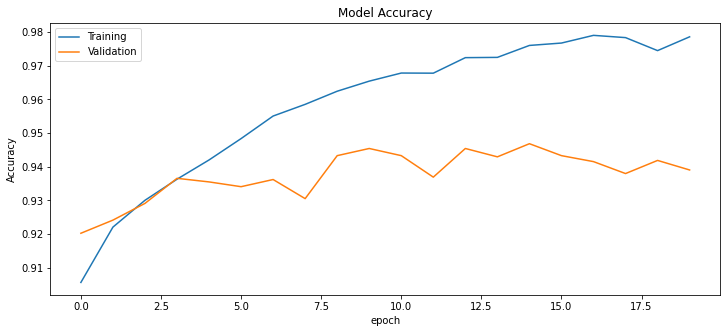

In [ ]:
plt.figure(figsize=(12, 5))
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

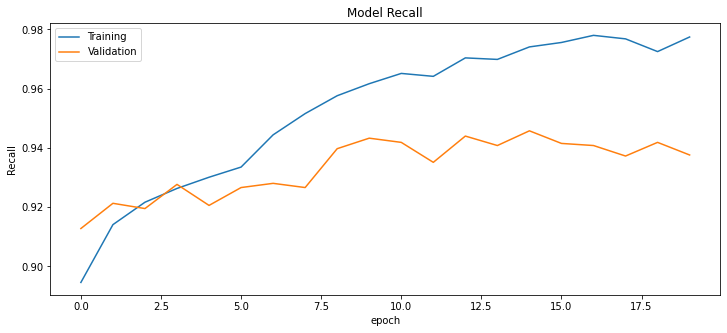

In [ ]:
plt.figure(figsize=(12, 5))
plt.plot(model_history.history['recall'])
plt.plot(model_history.history['val_recall'])
plt.title('Model Recall')
plt.ylabel('Recall')
plt.xlabel('epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

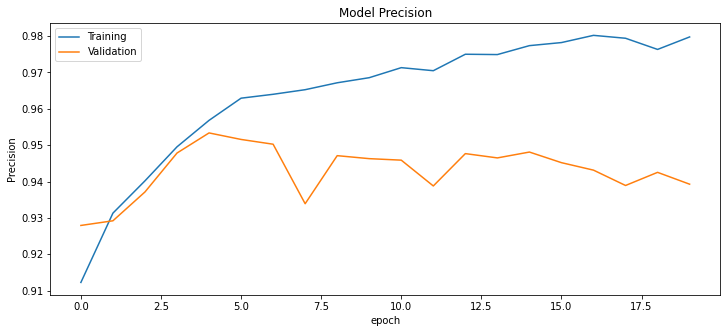

In [ ]:
plt.figure(figsize=(12, 5))
plt.plot(model_history.history['precision'])
plt.plot(model_history.history['val_precision'])
plt.title('Model Precision')
plt.ylabel('Precision')
plt.xlabel('epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

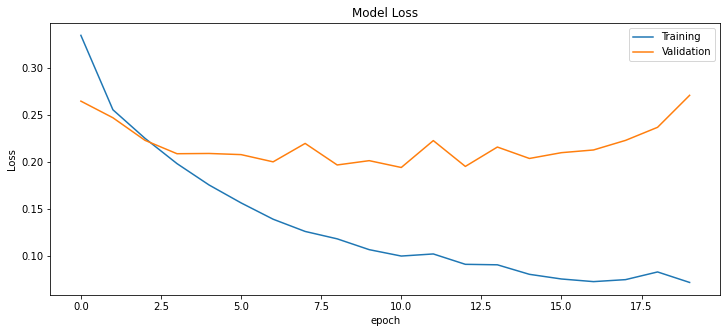

In [ ]:
plt.figure(figsize=(12, 5))
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

# Test on individual sentiment class

In [ ]:
Xpos_test = []
Xneu_test = []
Xneg_test = []
Ypos_test = []
Yneu_test = []
Yneg_test = []

for i in range(len(y_test)):
  if y_test[i] == 1:
    Xpos_test.append(x_test_vector[i])
    Ypos_test.append(y_test[i])
  elif y_test[i] == 0:
    Xneu_test.append(x_test_vector[i])
    Yneu_test.append(y_test[i])
  else:
    Xneg_test.append(x_test_vector[i])
    Yneg_test.append(y_test[i])

Xpos_test = np.asarray(Xpos_test)
Xneu_test = np.asarray(Xneu_test)
Xneg_test = np.asarray(Xneg_test)

Test on Positive sentiment test data

In [ ]:
predictions = model.predict(Xpos_test)

In [ ]:
predictions = np.argmax(predictions, axis=-1)
wrong = 0

for i in range(len(predictions)):
  if predictions[i] != 1:
    wrong = wrong + 1

print("Prediction Accuracy for sentiment 'positive': ", (len(predictions)-wrong)/len(predictions))

Prediction Accuracy for sentiment 'positive':  0.9696969696969697


Test on neutral sentiment test data

In [ ]:
predictions = model.predict(Xneu_test)

In [ ]:
predictions = np.argmax(predictions, axis=-1)
wrong = 0

for i in range(len(predictions)):
  if predictions[i] != 0:
    wrong = wrong + 1

print("Prediction Accuracy for sentiment 'neutral': ", (len(predictions)-wrong)/len(predictions))

Prediction Accuracy for sentiment 'neutral':  0.5871559633027523


Test on negative sentiment test data

In [ ]:
predictions = model.predict(Xneg_test)

In [ ]:
predictions = np.argmax(predictions, axis=-1)
wrong = 0

for i in range(len(predictions)):
  if predictions[i] != 2:
    wrong = wrong + 1

print("Prediction Accuracy for sentiment 'negative': ", (len(predictions)-wrong)/len(predictions))

Prediction Accuracy for sentiment 'negative':  0.7076023391812866
